# Spam Detection v1.0

In this project we will explore text message data and create models to predict if a message is spam or not.

Dataset is extracted from Applied Text Mining in Python - University of Michigan - Coursera

## Importing Libraries 

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from scipy import sparse
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from operator import itemgetter, attrgetter

## Reading & Exploring dataset 

The data contains two columns : 
* `text` : message content
* `target` : 'spam' or 'ham'. 
This will be converted to a binary variable : 
    * 1 for 'spam'     
    * 0 for 'ham'

In [165]:
spam_data = pd.read_csv('inputs/spam.csv')

spam_data['target'] = np.where(spam_data['target']=='spam',1,0)
spam_data.head(10)

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
5,FreeMsg Hey there darling it's been 3 week's n...,1
6,Even my brother is not like to speak with me. ...,0
7,As per your request 'Melle Melle (Oru Minnamin...,0
8,WINNER!! As a valued network customer you have...,1
9,Had your mobile 11 months or more? U R entitle...,1


<IPython.core.display.Javascript object>


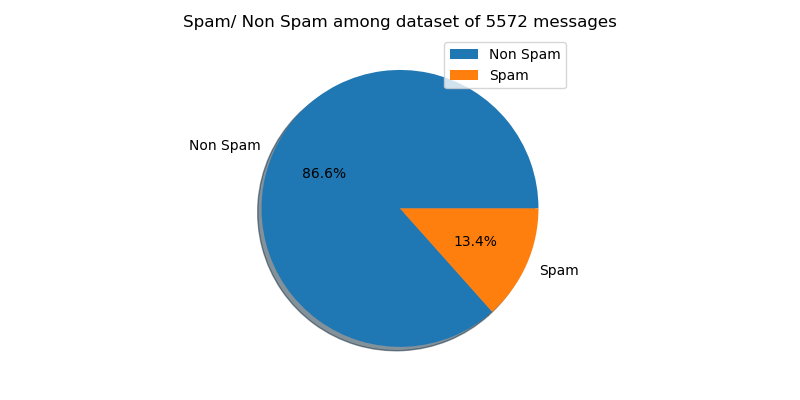

In [167]:
%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize = (8, 4))
serie_sum = spam_data.groupby(['target']).count()/len(spam_data)
ax.pie(serie_sum.values.ravel(), labels = ['Non Spam', 'Spam'],
           explode = [0., 0.],
           autopct = lambda x: str(round(x, 1)) + '%',
           shadow = True)
ax.set_title('Spam/ Non Spam among dataset of {} messages'.format(len(spam_data)))
ax.legend()
plt.tight_layout()
plt.show()

## Data Transformation Pipeline

* First we split data into train set and test set
* We Fit the training data `X_train` using a Count Vectorizer with default parameters into variable `count_vect`.
* We transform `X_train` and `X_test` with `count_vect`

>**Scikit-learn’s** `CountVectorizer` is used to convert a collection of text documents to a vector of term/token counts. It also enables the pre-processing of text data prior to generating the vector representation. This functionality makes it a highly flexible feature representation module for text.

In [148]:
X_train, X_test, y_train, y_test = train_test_split(spam_data['text'], 
                                                    spam_data['target'], 
                                                    random_state=0)
count_vect = CountVectorizer()
count_vect.fit(X_train)

longest_word = max(count_vect.get_feature_names(), key=len)
print('The longest word in the documents is :', longest_word)

The longest word in the documents is : com1win150ppmx3age16subscription


## 1 - Naive Bayes classifier model with CountVectorizer()

* We fit a multinomial Naive Bayes classifier model with smoothing `alpha=0.1`. 
* We calculate the area under the curve (AUC) score using the transformed test data.


In [149]:
count_vect = CountVectorizer()
count_vect.fit(X_train)
X_train_transformed = count_vect.transform(X_train)
X_test_transformed = count_vect.transform(X_test)
nb_cls = MultinomialNB(alpha=0.1)
nb_cls.fit(X_train_transformed, y_train)
score_auc = roc_auc_score(y_test, nb_cls.predict(X_test_transformed))
print('*'*70)
print('AUC Score on test set for Naive Bayes classifier with CounterVectorizer is {:.3f}'.format(score_auc))
print('*'*70)

df_scores = pd.DataFrame(columns=['Name' , 'Score'])
df_scores = df_scores.append({'Name' : 'Naive Bayes classifier with CounterVectorizer', 'Score' : round(score_auc,3)}, ignore_index=True)

**********************************************************************
AUC Score on test set for Naive Bayes classifier with CounterVectorizer is 0.972
**********************************************************************


In [150]:
df_scores

,Name,Score
0,Naive Bayes classifier with CounterVectorizer,0.972


### TF-IDF representation

Fit and transform the training data `X_train` using a Tfidf Vectorizer with default parameters. 10 Largest and Smallest tf-idf are displayed. 

>Transform a count matrix to a normalized tf or tf-idf representation. Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

>The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [151]:
tf_idf_vect = TfidfVectorizer().fit(X_train)
X_train_vectorized = tf_idf_vect.transform(X_train)
feature_names = np.array(tf_idf_vect.get_feature_names())
sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

# print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:20]]))
# print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-21:-1]]))

smallest_tf_idfs_series = pd.Series(dict(zip(feature_names[sorted_tfidf_index[:20]],
                                        X_train_vectorized.max(0).toarray()[0][sorted_tfidf_index[:20]])))

largest_tf_idfs_series = pd.Series(dict(zip(feature_names[sorted_tfidf_index[:-21:-1]],
                                        X_train_vectorized.max(0).toarray()[0][sorted_tfidf_index[:-21:-1]])))

smallest_tf_idfs_series = smallest_tf_idfs_series.reset_index()
smallest_tf_idfs_series = smallest_tf_idfs_series.sort_values([0, 'index'], ascending=[True, True])
smallest_tf_idfs_series = smallest_tf_idfs_series.set_index('index')

largest_tf_idfs_series = largest_tf_idfs_series.reset_index()
largest_tf_idfs_series = largest_tf_idfs_series.sort_values([0, 'index'], ascending=[False, True])
largest_tf_idfs_series = largest_tf_idfs_series.set_index('index')

print('Smallest tfidf :')
print('----------------')
print(smallest_tf_idfs_series[0])
print('*'*60)
print('Largest tfidf :')
print('---------------')

print(largest_tf_idfs_series[0])

Smallest tfidf :
----------------
index
aaniye          0.074475
athletic        0.074475
chef            0.074475
companion       0.074475
courageous      0.074475
dependable      0.074475
determined      0.074475
exterminator    0.074475
healer          0.074475
listener        0.074475
organizer       0.074475
pest            0.074475
psychiatrist    0.074475
psychologist    0.074475
pudunga         0.074475
stylist         0.074475
sympathetic     0.074475
venaam          0.074475
diwali          0.091250
mornings        0.091250
Name: 0, dtype: float64
************************************************************
Largest tfidf :
---------------
index
146tf150p    1.000000
645          1.000000
anything     1.000000
anytime      1.000000
beerage      1.000000
done         1.000000
er           1.000000
havent       1.000000
home         1.000000
lei          1.000000
nite         1.000000
ok           1.000000
okie         1.000000
thank        1.000000
thanx        1.000000
too    

## 2 - Naive Bayes classifier model with TfidfVectorizer()

* We Fit and transform the training data `X_train` using a Tfidf Vectorizer ignoring terms that have a document frequency strictly lower than **3**.

* Then fit a multinomial Naive Bayes classifier model with smoothing `alpha=0.1` and compute the area under the curve (AUC) score using the transformed test data.

In [152]:
vect = TfidfVectorizer(min_df=3).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)
score_auc = roc_auc_score(y_test, model.predict(X_test_transformed))
print('*'*70)
print('AUC Score on test set for Naive Bayes classifier with TfidfVectorizer is {:.3f}'.format(score_auc))
print('*'*70)

df_scores = df_scores.append({'Name' : 'Naive Bayes classifier with TfidfVectorizer', 'Score' : round(score_auc,3)}, ignore_index=True)

**********************************************************************
AUC Score on test set for Naive Bayes classifier with TfidfVectorizer is 0.942
**********************************************************************


## Feature Engineering

We compute the average length of documents (number of characters) for not spam and spam documents. We notive that **spam** document tends to be **longer**. 

Therefore, we will add a feature length to our train & test set.

In [153]:
spam_data['doc_length'] = spam_data.apply(lambda x : len(x.text), axis=1)
results = spam_data[['target','doc_length']].groupby('target').mean()
print('Average length for NON spam documents : {:.1f} words'.format(float(results.iloc[0])))
print('Average length for spam documents : {:.1f} words'.format(float(results.iloc[1])))

Average length for NON spam documents : 71.0 words
Average length for spam documents : 138.9 words


The following function allows to combine new features into the training data:

In [154]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

## 3 - Support Vector classifier model with TfidfVectorizer() + additional feature

* We Fit and transform the training data X_train using a Tfidf Vectorizer ignoring terms that have a document frequency strictly lower than **5**.

* Using this document-term matrix and an additional feature, **the length of document (number of characters)**, we fit a Support Vector Classification model with regularization `C=10000`. 

* We compute the area under the curve (AUC) score using the transformed test data.

In [155]:
vect = TfidfVectorizer(min_df=5).fit(X_train)
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

spam_data['doc_length'] = spam_data.apply(lambda x : len(x.text), axis=1)

X_doc_length_train = spam_data.loc[X_train.index].doc_length.values
X_doc_length_test = spam_data.loc[X_test.index].doc_length.values

X_train_transformed = add_feature(X_train_transformed,X_doc_length_train)

X_test_transformed = add_feature(X_test_transformed,X_doc_length_test)

model = SVC(C=10000, gamma='auto')
model.fit(X_train_transformed, y_train)
score_auc = roc_auc_score(y_test, model.predict(X_test_transformed))
print('*'*110)
print('AUC Score on test set for Support Vector classifier with TfidfVectorizer and additional feature is {:.3f}'.format(score_auc))
print('*'*110)

df_scores = df_scores.append({'Name' : 'Support Vector classifier with TfidfVectorizer and additional feature', 'Score' : round(score_auc,3)}, ignore_index=True)

**************************************************************************************************************
AUC Score on test set for Support Vector classifier with TfidfVectorizer and additional feature is 0.958
**************************************************************************************************************


What is the average number of digits per document for not spam and spam documents?

In [156]:
spam_data['digits_list'] = spam_data['text'].str.findall(r'\d')
spam_data['number_digits'] = spam_data.apply(lambda x : len(x.digits_list), axis=1)
results = spam_data[['target','number_digits']].groupby('target').mean()
print('Average number of digits for NON spam documents : {:.1f} words'.format(float(results.iloc[0])))
print('Average number of digits for spam documents : {:.1f} words'.format(float(results.iloc[1])))

Average number of digits for NON spam documents : 0.3 words
Average number of digits for spam documents : 15.8 words


## 4 - Logistic regression classifier model with TfidfVectorizer() + additional features

We fit and transform the training data `X_train` using a Tfidf Vectorizer ignoring terms that have a document frequency strictly lower than **5** and using **word n-grams from n=1 to n=3** (unigrams, bigrams, and trigrams).

We this document-term matrix and the following additional features:
* the length of document (number of characters)
* **number of digits per document**

* We fit a Logistic Regression model with regularization `C=100`. 
* Then we compute the area under the curve (AUC) score using the transformed test data.

In [157]:
vect = TfidfVectorizer(min_df=5, ngram_range=(1,3)).fit(X_train)
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

spam_data['digits_list'] = spam_data['text'].str.findall(r'\d')
spam_data['number_digits'] = spam_data.apply(lambda x : len(x.digits_list), axis=1)
spam_data['doc_length'] = spam_data.apply(lambda x : len(x.text), axis=1)

X_doc_length_train = spam_data.loc[X_train.index].doc_length.values
X_number_digits_train = spam_data.loc[X_train.index].number_digits.values

X_doc_length_test = spam_data.loc[X_test.index].doc_length.values
X_number_digits_test = spam_data.loc[X_test.index].number_digits.values

X_train_transformed = np.concatenate((X_train_transformed.toarray(),
                                     X_doc_length_train.reshape(-1,1), X_number_digits_train.reshape(-1,1)), axis=1)

X_test_transformed = np.concatenate((X_test_transformed.toarray(),
                                     X_doc_length_test.reshape(-1,1), X_number_digits_test.reshape(-1,1)), axis=1)

X_train_transformed=sparse.csr_matrix(X_train_transformed)
X_test_transformed=sparse.csr_matrix(X_test_transformed)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=100, solver='liblinear')
model.fit(X_train_transformed, y_train)
score_auc = roc_auc_score(y_test, model.predict(X_test_transformed))   
print('*'*120)
print('AUC Score on test set for Logistic Regression classifier with TfidfVectorizer and additional features is {:.3f}'.format(score_auc))
print('*'*120)

df_scores = df_scores.append({'Name' : 'Logistic Regression classifier with TfidfVectorizer and additional features', 'Score' : round(score_auc,3)}, ignore_index=True)

************************************************************************************************************************
AUC Score on test set for Logistic Regression classifier with TfidfVectorizer and additional features is 0.965
************************************************************************************************************************


What is the average number of non-word characters (anything other than a letter, digit or underscore) per document for not spam and spam documents?

In [158]:
spam_data['non_word_list'] = spam_data['text'].str.findall(r'\W')
spam_data['number_non_word'] = spam_data.apply(lambda x : len(x.non_word_list), axis=1)
results = spam_data[['target','number_non_word']].groupby('target').mean()
print('Average number of non-word characters for NON spam documents : {:.1f} words'.format(float(results.iloc[0])))
print('Average number of non-word characters for spam documents : {:.1f} words'.format(float(results.iloc[1])))

Average number of non-word characters for NON spam documents : 17.3 words
Average number of non-word characters for spam documents : 29.0 words


## 5 - Logistic regression classifier model with CountVectorizer() + additional features

* We Fit and transform the training data X_train using a Count Vectorizer ignoring terms that have a document frequency strictly lower than **5** and using **character n-grams from n=2 to n=5.**

*To tell Count Vectorizer to use character n-grams pass in `analyzer='char_wb'` which creates character n-grams only from text inside word boundaries. This should make the model more robust to spelling mistakes.*

* Using this document-term matrix and the following additional features:
    * the length of document (number of characters)
    * number of digits per document
    * **number of non-word characters (anything other than a letter, digit or underscore.)**

* We fit a Logistic Regression model with regularization C=100. 
* Then we compute the area under the curve (AUC) score using the transformed test data.

Also **find the 10 smallest and 10 largest coefficients from the model** and return them along with the AUC score in a tuple.

The list of 10 smallest coefficients should be sorted smallest first, the list of 10 largest coefficients should be sorted largest first.

The three features that were added to the document term matrix should have the following names should they appear in the list of coefficients:
['length_of_doc', 'digit_count', 'non_word_char_count']

In [159]:
vect = CountVectorizer(min_df=5, ngram_range=(2,5), analyzer='char_wb').fit(X_train)
X_train_transformed = vect.transform(X_train) 
X_test_transformed = vect.transform(X_test) 
spam_data['length_of_doc'] = spam_data.apply(lambda x : len(x.text), axis=1)
spam_data['digits_list'] = spam_data['text'].str.findall(r'\d')
spam_data['digit_count'] = spam_data.apply(lambda x : len(x.digits_list), axis=1)
spam_data['non_word_list'] = spam_data['text'].str.findall(r'\W')
spam_data['non_word_char_count'] = spam_data.apply(lambda x : len(x.digits_list), axis=1)

X_doc_length_train = spam_data.loc[X_train.index].length_of_doc.values
X_doc_length_test = spam_data.loc[X_test.index].length_of_doc.values
X_number_digits_train = spam_data.loc[X_train.index].digit_count.values
X_number_digits_test = spam_data.loc[X_test.index].digit_count.values
X_number_non_word_train = spam_data.loc[X_train.index].non_word_char_count.values
X_number_non_word_test = spam_data.loc[X_test.index].non_word_char_count.values

X_train_transformed = add_feature(X_train_transformed, [X_doc_length_train, X_number_digits_train, X_number_non_word_train])
X_test_transformed = add_feature(X_test_transformed, [X_doc_length_test, X_number_digits_test, X_number_non_word_test])

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=100, solver='liblinear')
model.fit(X_train_transformed, y_train)
score_auc = roc_auc_score(y_test, model.predict(X_test_transformed))   

liste_names = vect.get_feature_names()
liste_names.append('length_of_doc')
liste_names.append('digit_count')
liste_names.append('non_word_char_count')

lowest_coefficients = [x[1] for x in sorted(zip(model.coef_.T.ravel(), liste_names), reverse=False)[0:10]]
highest_coefficients = [x[1] for x in sorted(zip(model.coef_.T.ravel(), liste_names), reverse=True)[0:10]]

print('*'*110)
print('AUC Score on test set for Logistic Regression classifier with CountVectorizer and additional features is {:.3f}'.format(score_auc))
print('*'*110, '\n')
print('Features with lowest coefficents : ')
print('-----------------------')
print(lowest_coefficients, '\n')
print('Features with highest coefficents : ')
print('-----------------------')
print(highest_coefficients)

df_scores = df_scores.append({'Name' : 'Logistic Regression classifier with CountVectorizer and additional features', 'Score' : round(score_auc,3)}, ignore_index=True)

**************************************************************************************************************
AUC Score on test set for Logistic Regression classifier with CountVectorizer and additional features is 0.979
************************************************************************************************************** 

Features with lowest coefficents : 
-----------------------
['. ', '..', ' i', '? ', ' y', ' go', ':)', ' m', ' h', 'h '] 

Features with highest coefficents : 
-----------------------
['non_word_char_count', 'digit_count', 'ne', 'co', 'ia', 'ww', 'xt', ' x', 'mob', ' ch']


## Summary

The chart below represents the AUC results for each step

In [160]:
df_scores.set_index('Name',inplace=True)
df_scores.sort_values(by=['Score'],ascending=False, inplace=True)
df_scores.rename(columns={'Score' : 'AUC Score on Test Set' }, inplace=True)
df_scores

,AUC Score on Test Set
Name,
Logistic Regression classifier with CountVectorizer and additional features,0.979
Naive Bayes classifier with CounterVectorizer,0.972
Logistic Regression classifier with TfidfVectorizer and additional features,0.965
Support Vector classifier with TfidfVectorizer and additional feature,0.958
Naive Bayes classifier with TfidfVectorizer,0.942
